# Parallel Sorting : Analysis

## Summary

Parallelization of an embarrasingly parallel problem is certainly easy to do in Erlang, though the benefits of spreading a calculation across processors diminishes after the 2nd or 3rd processor.


## Notes

* 'dummy_sort' uses the internal Erlang lists:sort/1 method. It is provided as a baseline.


### The data :

The format is the same as for Part 1 with the addition of a 'procs' field at the beginning:

"['procs', 'alg', 'input', 'items', 'utc', 'ts', 'duration\n']"


In [48]:
with open("./perf/pperf-01.csv") as f:
    lines = f.readlines()
    for line in lines[:10]:
        items = line.split("|")
        print(items)

['procs', 'alg', 'input', 'items', 'utc', 'ts', 'duration', 'func\n']
['8', 'dummy_sort', 'random', '10', '14 Jun 2019 21:30:10.910728', '1560547810910746', '0.00000000', 'frag\n']
['8', 'dummy_sort', 'random', '10', '14 Jun 2019 21:30:10.911088', '1560547810911114', '0.00000000', 'rpcpmap\n']
['8', 'dummy_sort', 'random', '10', '14 Jun 2019 21:30:10.911344', '1560547810911370', '0.00000000', 'merge\n']
['8', 'dummy_sort', 'random', '10', '14 Jun 2019 21:30:10.908312', '1560547810910722', '0.001000', 'all\n']
['8', 'dummy_sort', 'random', '100', '14 Jun 2019 21:30:10.911833', '1560547810911859', '0.00000000', 'frag\n']
['8', 'dummy_sort', 'random', '100', '14 Jun 2019 21:30:10.912149', '1560547810912180', '0.00000000', 'rpcpmap\n']
['8', 'dummy_sort', 'random', '100', '14 Jun 2019 21:30:10.912411', '1560547810912442', '0.00000000', 'merge\n']
['8', 'dummy_sort', 'random', '100', '14 Jun 2019 21:30:10.911780', '1560547810911818', '0.001000', 'all\n']
['8', 'dummy_sort', 'random', '1000'

### Setup

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
from pandasql import sqldf
df = pd.read_csv("./perf/pperf-01.csv", delimiter="|")
pysqldf = lambda q: sqldf(q, globals())

### Q: Did the time to sort increase proportionally to the size of the inputs?
A: Looks exponential to me.

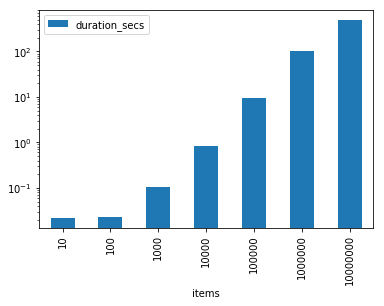

In [59]:
q = pysqldf("select items, sum(duration) as duration_secs from df group by items;")
q.plot.bar(x='items', y='duration_secs', logy=True)

### Q: Did adding more processesors and parallelizing the solution result in faster problem solving?
A: Uh oh. That looks like a big fat _NO_. In the graph below, the different colors represent the different number of processors that were enlisted by the parallelization function. The input datasets were chunked into the number of processors enlisted (from 3 to 8) and then processed in parallel via `rpc:pmap`. More on that below.

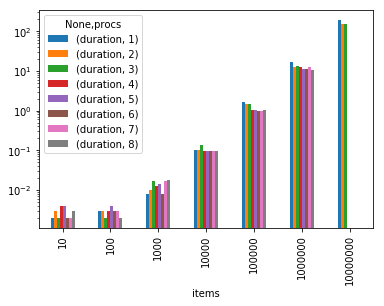

In [60]:
q = pysqldf("select items, procs, duration from df;")
q.groupby(['items', 'procs']).sum(axes='duration').unstack().plot.bar(logy=True, rot=90)

### Closeup on the items = 1000000

Looks like `7` processors was the sweet spot on my machine (W510 with 8 virtual cpus). But it's interesting that the results didn't vary by all that much.

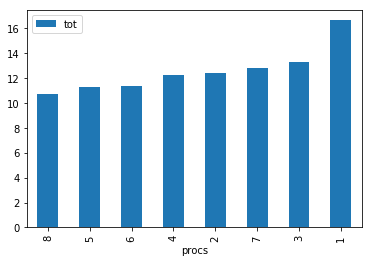

In [52]:
q = pysqldf("select items, procs, sum(duration) as tot from df where items == 1000000 group by procs order by tot asc;")
q.plot.bar(x='procs', y='tot')

So the question is, where did the time get spent and are the results an artifact of how I'm testing this? The results are definitely not what I expected, so let's dig in...

## Q: Is there something that is swamping the results?

I think so. The test chunks the input, farms each chunk out via rpc:pmap for evaluation by the sorting function `F`, and then reassembles the sorted chunks, `by processing the appended chunks with F`. I bet this last sort is swamping the results...and in fact, is a terrible idea as Part 1 showed that most of these algorithms do not behave particularly well with presorted inputs. 

code:

```erlang
parallelized_sort(FName, GName, OuterF, L, Procs, File) ->
    DataLen = length(L),
    Log = fun(N,T) ->
        dump(File, [io_lib:format(<<"~w|~s|~s|~w|~s|~w|~.8f|~s">>, [Procs, FName, GName, DataLen, format_utc_timestamp(), erlang:system_time(microsecond), T, N])]) end,
    {FragTime, Frags} = ?timeit(fragment(L, Procs)),
    Log(frag, FragTime),
    FuncNameAtom = list_to_atom(FName),
    {RPCTime, RPCRes} = ?timeit(rpc:pmap({?MODULE, FuncNameAtom}, [], Frags)),
    Log(rpcpmap, RPCTime),
    {MergeTime, Merged} = ?timeit(OuterF(lists:flatten(RPCRes))),
    Log(merge, MergeTime),
    Merged.
```

So note that this is essentially:

```erlang 
%% pseudocode
C = chunks(L)
%% Here the outer F is swamping the inner F
F(rpc:pmap(F(C)))
```

So is the OuterF swamping the results of the InnerF ?

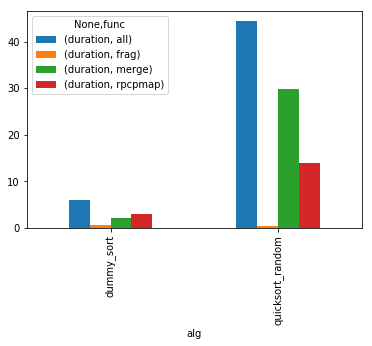

In [53]:
q = pysqldf("select alg, func, duration, items from df where items=1000000;")
q1 = pysqldf("select alg, func, duration from q;")
q1.groupby(['alg', 'func']).sum(axes='duration').unstack().plot.bar(logy=False, rot=90)

Above, note that the total duration, "all" is almost equal to the time required by the finalsort called 'merge'. The time required for the 'rpcmap' operation is considerably less (by about an order of magnitude) than the time required for the the final sort. Interesting.

## Remove Swamping

In the following results, I've made the following change to the code:

```erlang
C = chunks(L)

%% Use the existing lists:merge function to merge already sorted lists
lists:merge(rpc:pmap(F(C)))
```

Here's how that actually looks:

```erlang
parallelized_sort(FName, GName, L, Procs, File) ->
    DataLen = length(L),
    Log = fun(N,T) ->
        dump(File, [io_lib:format(<<"~w|~s|~s|~w|~s|~w|~.8f|~s">>, [Procs, FName, GName, DataLen, format_utc_timestamp(), erlang:system_time(microsecond), T, N])]) end,
    {FragTime, Frags} = ?timeit(fragment(L, Procs)),
    Log(frag, FragTime),
    FuncNameAtom = list_to_atom(FName),
    {RPCTime, RPCRes} = ?timeit(rpc:pmap({?MODULE, FuncNameAtom}, [], Frags)),
    Log(rpcpmap, RPCTime),
    {MergeTime, Merged} = ?timeit(lists:merge(RPCRes)),
    Log(merge, MergeTime),
    Merged.
```



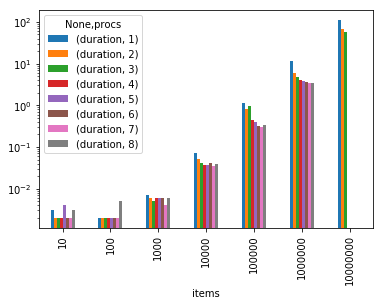

In [54]:
df = pd.read_csv("./perf/pperf-02.csv", delimiter="|")
q = pysqldf("select items, procs, duration from df;")
q.groupby(['items', 'procs']).sum(axes='duration').unstack().plot.bar(logy=True, rot=90)

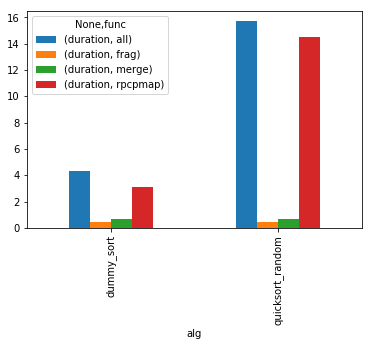

In [55]:
q = pysqldf("select alg, func, duration, items from df where items=1000000;")
q1 = pysqldf("select alg, func, duration from q;")
q1.groupby(['alg', 'func']).sum(axes='duration').unstack().plot.bar(logy=False, rot=90)

Ok, so the swamping has been removed and almost all the time is attributed to the RPC calls. Now, how well do these algorithms perform when distributed?

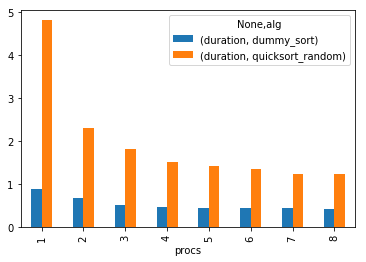

In [56]:
q = pysqldf("select procs, alg, func, duration from df where func='all' and items=1000000;")
q.groupby(['procs', 'alg']).sum(axes='duration').unstack().plot.bar(logy=False, rot=90)

## Summary

The greatest gains for quicksort happen to be going from one processor to two, essentially halving the time to do the work. Adding a third and fourth processor had successively smaller gains to performance, leading us to Ahmdals Law:

https://en.wikipedia.org/wiki/Amdahl%27s_law


TODO: Graph what Ahmdals Law using the collected data
http://tutorials.jenkov.com/java-concurrency/amdahls-law.html